In [4]:
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from ml.common.data_utils.data_modules import HiggsDataset
from ml.common.data_utils.syn_datacreator import create_custom_multidim_dataset
from diffusers import DiffuserDDPM, DiffuserDDPMeps
from model import NoisePredictorUNet
from losses import LossDDPM, LossDDPMNoise
from samplers import SimpleSampler, SamplerNoise
from ml.common.utils.utils import EMA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [1]:
import os
print(os.path.abspath('.'))

c:\Users\Uporabnik\Documents\IJS-F9\korlz\ml\diffusion\ddpm


Synthetic data

In [3]:
# # data
# data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
#     torch.distributions.Categorical(torch.tensor([0.5, 1])),
#     torch.distributions.Normal(torch.tensor([-4.0, 4.0]), torch.tensor([0.5, 0.5])),
# )

# datasetraw1d = data_distribution.sample(torch.Size([10000, 1]))
# print(datasetraw1d)

# dataset = DatasetNoLabels(datasetraw1d)
# batches = DataLoader(dataset, num_workers=0, batch_size=512, shuffle=True)

# # sns.histplot(next(iter(batches)), bins=30)
# # plt.show()

# 

In [8]:
batch_size=512

In [9]:
D_syn = 3
datasetraw = create_custom_multidim_dataset(n_samples=20000, n_features=D_syn, label_random=True, signal_frac=0.5, seed=123)
print("dataset shape:", datasetraw.shape)   # (10000, 3)
print(datasetraw[:5])

dataset shape: (20000, 4)
[[-3.550892  -1.0142367 -7.4624577  0.       ]
 [ 4.622796   1.6087942  3.7642446  1.       ]
 [-4.515475  -2.5092688 -3.500204   0.       ]
 [-4.6891136 -4.7863035 -4.834843   0.       ]
 [-3.4597535 -3.6463473 -4.970148   0.       ]]


In [10]:
features_syn = [f'f{i}' for i in range(D_syn)]

In [8]:
# # data
# data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
#     torch.distributions.Categorical(torch.tensor([0.5, 1])),
#     torch.distributions.Normal(torch.tensor([-4.0, 4.0]), torch.tensor([0.5, 0.5])),
# )

# datasetraw1d = data_distribution.sample(torch.Size([10000, 1]))


# dataset = DatasetNoLabels(datasetraw1d)
# batches = DataLoader(dataset, num_workers=0, batch_size=512, shuffle=True)
# print(next(iter(batches)))
# sns.histplot(next(iter(batches)), bins=30)
# plt.show()

In [11]:
# X_syn, labels_syn = datasetraw[:, :-1], datasetraw[:, -1][:, None]
train_data_syn, val_data_syn = train_test_split(datasetraw, train_size=0.8)

print(train_data_syn.shape, val_data_syn.shape)
train_dataset_syn = HiggsDataset(train_data_syn)
val_dataset_syn = HiggsDataset(val_data_syn)

batches_train = DataLoader(train_dataset_syn, num_workers=0, batch_size=batch_size, shuffle=True)
batches_val = DataLoader(train_dataset_syn, num_workers=0, batch_size=batch_size, shuffle=True)

X_syn, labels_syn = next(iter(batches_train))

# fig, ax = plt.subplots(D_syn, 1)
# for idx, feature in enumerate(features_syn[:D_syn]): 
#     sns.histplot(X_syn[:, idx][:, None], bins=30, ax=ax[idx])
# plt.show()

(16000, 4) (4000, 4)


In [13]:
TIME_STEPS = 1000
BETA = 0.04
num_epochs = 20

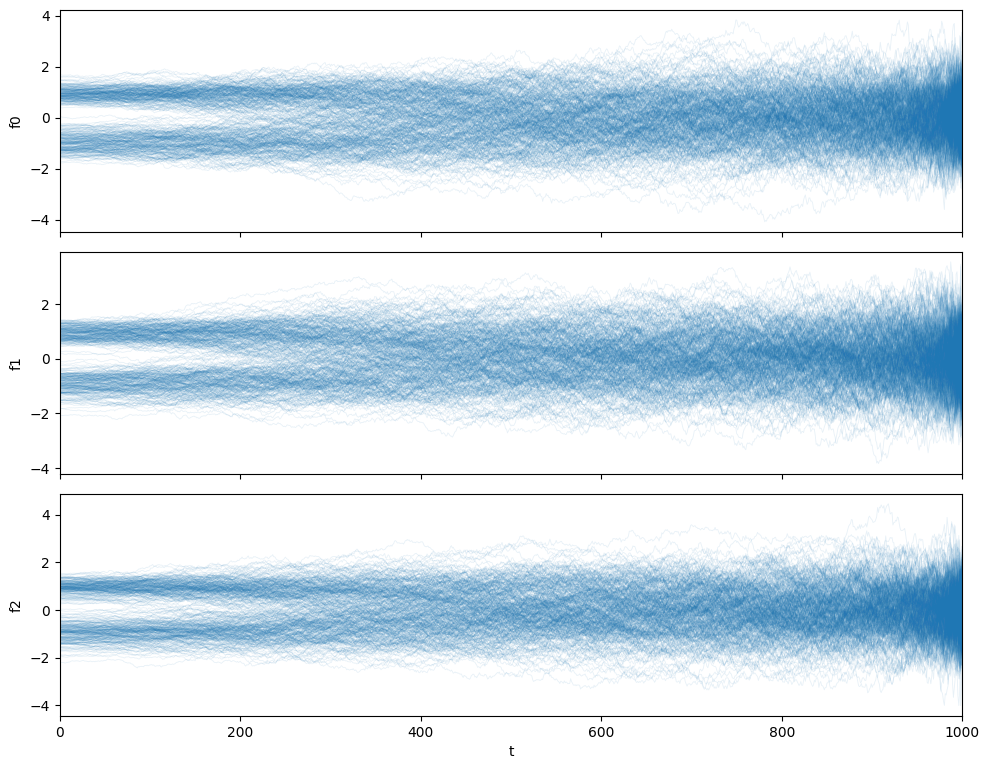

In [ ]:
diffuser2 = DiffuserDDPMeps(timesteps=TIME_STEPS, scheduler="cosine", device=device)

X0 = X_syn.to(device)            # shape [B, D]
B, D = X0.shape
T = diffuser2.T                  # number of timesteps (T)
betas = diffuser2.betas.to(device)

# iterative forward diffusion: x0 -> x1 -> ... -> x_T
xt = X0.clone()
samples = [xt.detach().cpu()]    # list of tensors [B,D], include x0
for t_idx in range(T):
    beta_t = betas[t_idx]                       # scalar tensor on device
    sqrt1m = torch.sqrt(1.0 - beta_t)
    std = torch.sqrt(beta_t)
    # apply transition: x_{t+1} = sqrt(1-beta_t) * x_t + sqrt(beta_t) * noise
    noise = torch.randn_like(xt, device=device)
    xt = sqrt1m * xt + std * noise
    samples.append(xt.detach().cpu())

# stack into (T+1, B, D) on CPU
samples_tensor = torch.stack(samples, dim=0)   # shape (T+1, B, D)
T_plus_1 = samples_tensor.shape[0]
time_axis = np.arange(T_plus_1)

# plotting: one subplot per feature, plot up to max_traj trajectories
import matplotlib.pyplot as plt
max_traj = 400               # cap number of trajectories to plot for clarity
plot_traj = min(B, max_traj)

fig, axs = plt.subplots(D, 1, figsize=(10, 2.6 * D), sharex=True)
if D == 1:
    axs = [axs]

for feat_idx in range(D):
    ax = axs[feat_idx]
    # shape (plot_traj, T+1)
    trajs = samples_tensor[:, :plot_traj, feat_idx].permute(1, 0).numpy()
    for traj in trajs:
        ax.plot(time_axis, traj, color="C0", alpha=0.1, linewidth=0.6)
    ax.set_ylabel(features_syn[feat_idx] if 'features_syn' in globals() else f"feat{feat_idx}")
    ax.set_xlim(0, T)
    ax.grid(False)

axs[-1].set_xlabel("t")
plt.tight_layout()
plt.show()

In [15]:
#instantiate 

# diffuser2 = DiffuserDDPMeps(timesteps=TIME_STEPS, beta_start=4e-3, beta_end=8e-3, scheduler='linear', device=device)
diffuser2 = DiffuserDDPMeps(timesteps=TIME_STEPS, scheduler='cosine', device=device)
# model2 = NoisePredictorMLP(data_dim=D, hidden_dim=128, n_hidden_layers=2, time_emb_dim=32, timesteps=TIME_STEPS)
model2 = NoisePredictorUNet(data_dim=D, base_dim=128, depth=2, time_emb_dim=32, timesteps=TIME_STEPS)

loss_fn2 = LossDDPMNoise(model2, diffuser2)
sampler2 = SamplerNoise(model2, diffuser2)

In [16]:
def train2(model, diffuser, train_dataloader, val_dataloader, device, max_epochs=10, lr=1e-3):
    """
    Train a noise-predicting DDPM model (eps prediction).
    - model: NoisePredictorMLP
    - diffuser: DiffuserDDPMeps (schedule helper) already configured with timesteps/betas
    - train_dataloader, val_dataloader: yield (features, labels) but labels are unused here
    """
    model.to(device)
    diffuser.to(device)                     # ensure schedule tensors live on device (q_sample uses them)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = LossDDPMNoise(model, diffuser)  # expects x0 when called
    ema = EMA(model, decay=0.9999, device=device, start_step=0)

    epoch_train_loss = []
    epoch_val_loss = []

    for epoch in range(max_epochs):
        model.train()
        train_loss = []
        loop = tqdm(train_dataloader, leave=False,
                    desc=f"Epoch {epoch+1}/{max_epochs} training")
        for features_batch, labels_batch in loop:
            # move batch to device
            features_batch = features_batch.to(device)
            optimizer.zero_grad()
            loss = loss_func(features_batch)    
            loss.backward()
            optimizer.step()
            ema.update(model)

            train_loss.append(loss.item())
            loop.set_postfix({'batch_loss': f"{loss.item():.4f}"})

        epoch_avg = float(np.mean(train_loss)) if len(train_loss) > 0 else 0.0
        epoch_train_loss.append(epoch_avg)
        print(f"Epoch {epoch+1}/{max_epochs} avg_loss={epoch_avg:.4f}")

        # ---------- validation ----------
        model.eval()
        val_loss = []
        loop_val = tqdm(val_dataloader, leave=False,
                        desc=f"Epoch {epoch+1}/{max_epochs} validation")

        with torch.no_grad():
            for features_batch_val, labels_batch_val in loop_val:
                features_batch_val = features_batch_val.to(device)

                # call loss_func with raw x0 for validation as well
                loss_val = loss_func(features_batch_val)
                val_loss.append(loss_val.item())
                loop_val.set_postfix({'val_batch_loss': f"{loss_val.item():.4f}"})

        epoch_avg_val = float(np.mean(val_loss)) if len(val_loss) > 0 else 0.0
        epoch_val_loss.append(epoch_avg_val)
        print(f"Epoch {epoch+1}/{max_epochs} avg_loss_val={epoch_avg_val:.4f}")

    return model, epoch_train_loss, epoch_val_loss

In [17]:
model2_trained, epoch_train_loss2, epoch_val_loss2 = train2(
    model2, diffuser2, batches_train, batches_val, device, max_epochs=20
)

Epoch 1/20 training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/20 avg_loss=0.5542


Epoch 1/20 avg_loss_val=0.4834


Epoch 2/20 avg_loss=0.4085


Epoch 2/20 avg_loss_val=0.3417


Epoch 3/20 avg_loss=0.3225


Epoch 3/20 avg_loss_val=0.3045


Epoch 4/20 avg_loss=0.3030


Epoch 4/20 avg_loss_val=0.2922


Epoch 5/20 avg_loss=0.2992


Epoch 5/20 avg_loss_val=0.3109


Epoch 6/20 avg_loss=0.2955


Epoch 6/20 avg_loss_val=0.2957


Epoch 7/20 avg_loss=0.2909


Epoch 7/20 avg_loss_val=0.2935


Epoch 8/20 avg_loss=0.2924


Epoch 8/20 avg_loss_val=0.2969


Epoch 9/20 avg_loss=0.3046


Epoch 9/20 avg_loss_val=0.2957


Epoch 10/20 avg_loss=0.2947


Epoch 10/20 avg_loss_val=0.2944


Epoch 11/20 avg_loss=0.2988


Epoch 11/20 avg_loss_val=0.2896


Epoch 12/20 avg_loss=0.2928


Epoch 12/20 avg_loss_val=0.2886


Epoch 13/20 avg_loss=0.2902


Epoch 13/20 avg_loss_val=0.2922


Epoch 14/20 avg_loss=0.2947


Epoch 14/20 avg_loss_val=0.2989


Epoch 15/20 avg_loss=0.2908


Epoch 15/20 avg_loss_val=0.2880


Epoch 16/20 avg_loss=0.2880


Epoch 16/20 avg_loss_val=0.2902


Epoch 17/20 avg_loss=0.2836


Epoch 17/20 avg_loss_val=0.2892


Epoch 18/20 avg_loss=0.2809


Epoch 18/20 avg_loss_val=0.2999


Epoch 19/20 avg_loss=0.2944


Epoch 19/20 avg_loss_val=0.2914


Epoch 20/20 avg_loss=0.2905


Epoch 20/20 avg_loss_val=0.2893


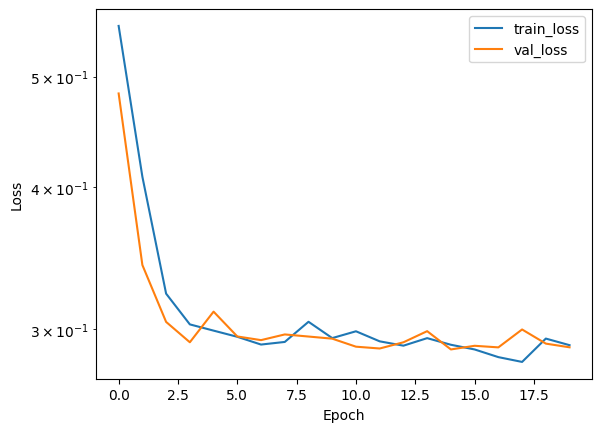

In [18]:
plt.plot(epoch_train_loss2, label='train_loss')
plt.plot(epoch_val_loss2, label='val_loss')
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [23]:
sample_count = 4000   # number of generated samples to draw
sampler_batch = 512   # chunk size for sampler
# --------------------

sampler = SamplerNoise(model2_trained, diffuser2)
ema = EMA(model2_trained, decay=0.9999, device=device, start_step=0)

In [ ]:
# draw samples (final x0). sampler.sample returns a CPU tensor per the earlier class.
ema.apply_to(model2_trained)
gen_samples = sampler.sample(batch_size=sample_count, device=next(model2_trained.parameters()).device, mean_only=False)
ema.restore(model2_trained)
# If your SamplerNoise returns CPU already, this is still safe.
if isinstance(gen_samples, torch.Tensor):
    gen_samples = gen_samples.cpu().numpy()

In [24]:
#real data (not in batches)
real, real_l = datasetraw[:, :-1], datasetraw[:, -1][:, None]

scaler = preprocessing.StandardScaler().fit(real)

real = scaler.transform(real)

if isinstance(real, torch.Tensor):
    real = real.cpu().numpy()

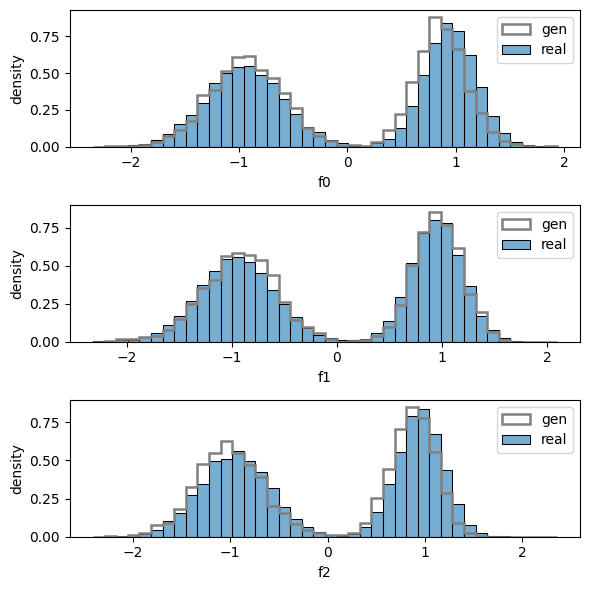

In [25]:

# dims and feature names (fallback)
D_syn = real.shape[1]
features_list = globals().get("features_syn", [f"f{i}" for i in range(D_syn)])

# Plot per-feature histograms aligned
fig, axes = plt.subplots(D_syn, 1, figsize=(6, 2 * D_syn), sharex=False)
if D_syn == 1:
    axes = [axes]

for idx, ax in enumerate(axes):
    # compute bins from combined data for alignment
    combined = np.concatenate([real[:, idx], gen_samples[:, idx]])
    bins = np.histogram_bin_edges(real[:, idx], bins=40)

    # real filled hist
    sns.histplot(real[:, idx], bins=bins, ax=ax, stat="density", color='C0', alpha=0.6, label='real')

    # generated outline histogram
    ax.hist(gen_samples[:, idx], bins=bins, density=True, histtype='step', lw=1.8, color='gray', label='gen')

    ax.set_xlabel(features_list[idx])
    ax.set_ylabel("density")
    ax.legend()

plt.tight_layout()
plt.show()